In [33]:
import pandas as pd

df = pd.read_csv("Twitter_Analysis.csv")
df.head()
# First we decide to remove unnecessary cols, including index, 
# In this dataset there are 2 types of labels, majority target and binary decision, we decided to choose the majority target as the true label 
df.drop(['Unnamed: 0', 'BinaryNumTarget', 'statement', 'tweet', 'embeddings'], axis=1, inplace=True)
df.head()
df['majority_target'].value_counts()


majority_target
True     68985
False    65213
Name: count, dtype: int64

In [34]:
from sklearn.preprocessing import MinMaxScaler

df['majority_target'] = df['majority_target'].astype(int)

cols_to_min_max = ['followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'listed_count', 'mentions', 'replies', 'quotes', 'retweets', 'favourites_count', 'hashtags', 'created_at', 'URLs', 'unique_count', 'total_count', 'Word count', 'Max word length', 'Min word length', 'Avg word length', 'present_verbs', 'past_verbs', 'adjectives', 'adpositions', 'adverbs', 'adpositions', 'pronouns', 'TOs', 'determiners', 'conjunctions', 'dots', 'exclamation', 'questions', 'ampersand', 'capitals' , 'digits' , 'long_word_freq', 'short_word_freq']

cols_to_min_max = list(set(cols_to_min_max))

# Filter only existing columns to avoid KeyError
cols_to_scale = [col for col in cols_to_min_max if col in df.columns]

# Apply MinMaxScaler
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

X = df.drop('majority_target', axis=1)
y = df['majority_target']

In [35]:
#Feature Engineering
X['favourites_per_follower'] = X['favourites_count'] / (X['followers_count'] + 1)
X['retweet_ratio'] = X['retweets'] / (X['statuses_count'] + 1)



In [38]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Initialize base model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

# Fit GridSearch to training data
grid_search.fit(X_train, y_train)

# Display best parameters
print("Best parameters found:", grid_search.best_params_)

# Evaluate best model on test set
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.6781296572280179
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67     13059
           1       0.69      0.68      0.68     13781

    accuracy                           0.68     26840
   macro avg       0.68      0.68      0.68     26840
weighted avg       0.68      0.68      0.68     26840



In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model with best parameters
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

best_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_rf.predict(X_test)


Test Accuracy: 0.6781296572280179
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67     13059
           1       0.69      0.68      0.68     13781

    accuracy                           0.68     26840
   macro avg       0.68      0.68      0.68     26840
weighted avg       0.68      0.68      0.68     26840



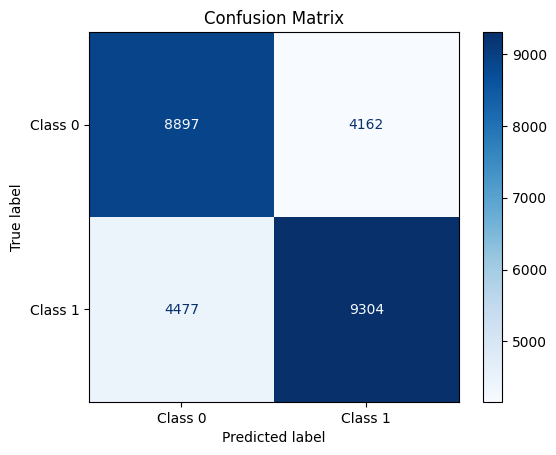

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Generate the confusion matrix
cm = confusion_matrix(y_test, best_rf.predict(X_test))

# Display the confusion matrix with a different color map
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

# Change the color map (e.g., 'Blues', 'coolwarm', 'viridis', 'plasma', etc.)
disp.plot(cmap='Blues')

# Optionally, add a title and show the plot
plt.title('Confusion Matrix')
plt.show()